In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import TextSplitter
from langchain_community.llms import Ollama
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated,Optional
from typing_extensions import TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from typing import Annotated, List, Optional
from langgraph.graph import StateGraph
from langchain.schema import BaseMessage

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    parsed: dict
    decision: Annotated[Optional[str], "Which travel strategy to use"]
    arrival_time: Annotated[Optional[str], "Estimated arrival time"]
    transportation_summary:Annotated[Optional[str],"Final Transport plan"]
    weather_data:list
    hotels_info:Optional[str]
    # estimated_budget:Optional[int]
    user_feedback:Optional[str]
    human_review_result:Optional[str]
    llm_routing_decision:Optional[str]
    human_feedback:Optional[str]
    plan:Optional[str]


from langgraph.graph import StateGraph
graph_builder = StateGraph(State)


from langchain_groq import ChatGroq
llm=ChatGroq(model="llama3-70b-8192")

In [3]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_groq import ChatGroq
from langchain.schema.messages import HumanMessage
from langchain.memory import ConversationBufferMemory

import os
from dotenv import load_dotenv

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
import pandas as pd

def extract_trip_fields(user_input:str):
    import os
    load_dotenv()
    groq_api_key = os.getenv("GROQ_API_KEY")
    # 1. Define the fields to extract
    response_schemas = [
        ResponseSchema(name="origin", description="Starting location (e.g., Delhi)"),
        ResponseSchema(name="destination", description="Trip destination (e.g., Paris)"),
        ResponseSchema(name="start_date", description="Start date of trip (YYYY-MM-DD)"),
        ResponseSchema(name="end_date", description="End date of trip (YYYY-MM-DD)"),
        ResponseSchema(name="duration", description="Duration of trip (in days)"),
        # ResponseSchema(name="budget", description="Approximate budget in INR"),
        ResponseSchema(name="preferences", description="List of interests like food, nature, adventure"),
        ResponseSchema(name="src_IATA", description="Origin IATA code"),
        ResponseSchema(name="dest_IATA", description="Destination IATA code"),
        ResponseSchema(name="nearby_src_city", description="Source IATA code city "),
        ResponseSchema(name="nearby_dest_city", description="Destination IATA code city "),
        ResponseSchema(name="Persons",description="No. of persons going to the trip")
    ]

    # 2. Create the parser
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    format_instructions = output_parser.get_format_instructions()
    # 3. Create the prompt

    prompt = PromptTemplate(
        template="""
        Extract the following information from the text below.
        If u get the start date and duration , automatically calculate end date accordingly
        {format_instructions}

        Text:
        {input_text}
        """,
        input_variables=["input_text"],
        partial_variables={"format_instructions": format_instructions}
    )

    # 4. Input text
    system_instructions = """
    You are a helpful travel planner.
    ONLY return valid JSON with the following keys:
    "origin", "destination", "start_date", "end_date", "duration", "budget", "preferences", "src_IATA", "dest_IATA","nearby_src_city","nearby_dest_city","Persons"
    Do NOT include text or explanations outside the JSON block.
    """
    
    user_input+='Also convert the source and destination into IATA codes.If the IATA code does not exists tell, then tell nearby city IATA code ,Also tell the nearby city name whose IATA Code you are using ,  for eg.) Aligarh has no IATA code , so tell IATA code for Delhi as DEL and also telll the city name, Also tell the IATA code of destination , and if IATA code of destination is not available , tell nearby city IATA Code and also mention the city name'
    'In neaby_dest_city tell the name of city whose IATA code you are using. ALways make sure that src_IATA, dest_IATA, nearby_src_city,nearby_dest_city are never empty'
    
    from langchain.schema import SystemMessage, HumanMessage

    messages = [
        SystemMessage(content=system_instructions),
        HumanMessage(content=prompt.format(input_text=user_input))
    ]
    llm = ChatGroq(
        groq_api_key=groq_api_key,
        model="meta-llama/llama-4-scout-17b-16e-instruct"
    )

    response = llm.invoke(messages)
    
    print("Raw LLM Output:\n", response.content)

    # 8. Parse the structured output
    parsed = output_parser.parse(response.content)

    # parsed["src_IATA"] = get_iata_code(parsed.get("origin", ""))
    # parsed["dest_IATA"] = get_iata_code(parsed.get("destination", ""))

    return parsed

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests
from datetime import datetime, timedelta
from langchain.tools import Tool
from time import sleep
import pandas as pd

def get_abhibus_buses(origin :str, destination :str, date_str :str)->dict:
    """
    Scrapes Abhibus.com for available buses between `origin` and `destination` on a specific `date_str` (DD/MM/YYYY).
    
    Returns:
        dict: Contains list of bus info or error message.
    """
    
    # -------------------- Setup WebDriver --------------------
    options = Options()
    options.add_argument("--start-maximized")
    driver = webdriver.Chrome(options=options)
    wait = WebDriverWait(driver, 15)
    driver.get("https://www.abhibus.com")

    def enter_location(xpath, location_name):
        input_elem = wait.until(EC.element_to_be_clickable((By.XPATH, xpath)))
        input_elem.clear()
        input_elem.click()
        input_elem.send_keys(location_name)
        sleep(1)
        input_elem.send_keys(Keys.DOWN)
        input_elem.send_keys(Keys.ENTER)

    try:
        # Step 1: Fill From & To
        print("🛣️ Entering locations...")
        from_xpath = '//*[@id="search-from"]/div[1]/div/div/div/div[2]/input'
        to_xpath = '//*[@id="search-to"]/div/div/div/div/div[2]/input'

        enter_location(from_xpath, origin)
        enter_location(to_xpath, destination)

        # Step 2: Set Date via JS
        date_input = driver.find_element(By.XPATH, '//input[@placeholder="Onward Journey Date"]')
        driver.execute_script("arguments[0].value = arguments[1];", date_input, date_str)
        driver.execute_script("""
            const evt = new Event('input', { bubbles: true });
            arguments[0].dispatchEvent(evt);
        """, date_input)
        print(f"📅 Date set to {date_str}")

        # Step 3: Click Search
        search_btn = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="search-button"]/a')))
        search_btn.click()
        print("🔍 Triggering search...")
        sleep(5)

        # Get current URL and convert date format
        search_url = driver.current_url

        def update_abhibus_url(url, desired_date):
            return url.replace(url.split("/")[-2], desired_date.replace("/", "-"))

        updated_url = update_abhibus_url(search_url, date_str)
        driver.get(updated_url)
        print(f"📎 Updated booking URL: {updated_url}")
        sleep(3)

        # Scrape all required fields
        print("🔄 Collecting data...")
        company_elements = driver.find_elements(By.XPATH, '//h5[@class="title"]')
        companies = [elem.text for elem in company_elements]

        times = driver.find_elements(By.XPATH, '//div[@class="text-sm col auto"]/span')
        times = [time.text for time in times]
        dept_time = times[::2]
        arr_time = times[1::2]

        bus_fare = driver.find_elements(By.XPATH, '//span[@class="fare text-neutral-800"]')
        fare = [f.text for f in bus_fare]

        avl_seats = driver.find_elements(By.XPATH, '//div[@class="row seat-info bd-success-400 text-success-600 bg-success-50"]/div/div')
        seats_avl = [s.text for s in avl_seats]

        # Trim lists to the minimum length to avoid mismatch
        min_len = min(len(companies), len(dept_time), len(arr_time), len(fare), len(seats_avl))
        df = pd.DataFrame({
            "Bus Name": companies[:min_len],
            "Departure Time": dept_time[:min_len],
            "Arrival Time": arr_time[:min_len],
            "Fare": fare[:min_len],
            "Seat Availability": seats_avl[:min_len],
            "Booking Link": [updated_url] * min_len
        })

        print("✅ Scraping completed successfully.")
        return df

    finally:
        driver.quit()

In [5]:
def find_cabs(origin: str, destination: str, date: str = None, time: str = None, persons:int=1) -> dict:
    from langchain_tavily import TavilySearch

    tool = TavilySearch()
    
    prompt = f"Give me cab details from {origin} to {destination}"
    if persons:
        prompt+= f"for {persons} persons"
    if date:
        prompt += f" on {date}"
    if time:
        prompt += f" at {time}"
    prompt += ". Provide the fare also."

    return tool.invoke(prompt)


In [6]:
import pandas as pd
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import re

# Load station data
df_stations = pd.read_excel('Station_name_8477.xlsx')
df_stations.columns = [col.replace("\n", " ").strip() for col in df_stations.columns]

# Helper: Get station info (prioritize NSG1/NSG2)
def get_station_info(city_name):
    pattern = r'\b' + re.escape(city_name) + r'\b'

    # Step 1: Match city name in Station Name or District
    matches = df_stations[
        df_stations['Station Name'].str.contains(pattern, case=False, na=False, regex=True) |
        df_stations['District'].str.contains(pattern, case=False, na=False, regex=True)
    ]

    if not matches.empty:
        return sort_main_stations(matches)

    # Step 2: Match exact district
    matching_districts = df_stations[df_stations['District'].str.lower() == city_name.lower()]
    if not matching_districts.empty:
        return sort_main_stations(matching_districts)

    return pd.DataFrame(columns=['Station Name', 'Station Code'])

# ✅ FIXED: Prioritize main stations (NSG1 and NSG2 first)
def sort_main_stations(df):
    priority = {'NSG1': 1, 'NSG2': 2, 'NSG3': 3, 'NSG4': 4, 'NSG5': 5, 'NSG6': 6}

    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Assign priority safely using .loc
    df.loc[:, '__priority__'] = df['New Station Category'].map(priority).fillna(999)

    sorted_df = df.sort_values(by='__priority__').drop(columns='__priority__')
    return sorted_df[['Station Name', 'Station Code']].drop_duplicates().reset_index(drop=True)

# Helper: Create station slug for URL
def format_station_slug(station_name, station_code):
    return f"{station_name.strip().replace('.', '').replace(' ', '-').upper()}-{station_code}"

# 🎯 Main Function
def get_etrain_trains(source_city:str, dest_city:str, user_date:str) -> pd.DataFrame:
    try:
        date_obj = datetime.strptime(user_date, "%d/%m/%Y")
    except ValueError:
        print("❌ Invalid date format. Use dd/mm/yyyy.")
        return pd.DataFrame()

    day = date_obj.day
    month = date_obj.strftime("%b")
    year = date_obj.year

    # Get station info
    src = get_station_info(source_city)
    dst = get_station_info(dest_city)

    if src.empty or dst.empty:
        print("❌ Source or destination station not found.")
        return pd.DataFrame()

    src_slug = format_station_slug(src.iloc[0]['Station Name'], src.iloc[0]['Station Code'])
    dst_slug = format_station_slug(dst.iloc[0]['Station Name'], dst.iloc[0]['Station Code'])
    url = f"https://etrain.info/trains/{src_slug}-to-{dst_slug}"
    print(f"[INFO] URL: {url}")

    # Launch browser
    driver = webdriver.Chrome()
    driver.get(url)
    wait = WebDriverWait(driver, 20)
    time.sleep(2)

    # Select calendar date
    date_icon = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".datepicker")))
    date_icon.click()
    time.sleep(1)

    # Loop to match month/year
    for _ in range(12):
        displayed_month_year = driver.find_element(By.CLASS_NAME, "monthDsp").get_attribute("value").strip()
        if displayed_month_year == f"{month} {year}":
            break
        next_btn = driver.find_element(By.CSS_SELECTOR, "input.nav[type='button'][value='>']")
        next_btn.click()
        time.sleep(0.5)

    # Select day
    day_cells = driver.find_elements(By.XPATH, f"//input[@type='button' and @value='{day}']")
    if not day_cells:
        print("❌ Unable to select the specified date.")
        driver.quit()
        return pd.DataFrame()
    day_cells[0].click()

    # Wait for train list
    time.sleep(2)
    rows = driver.find_elements(By.XPATH, '//div[@class="trnlstcont borderbottom rnd5 bx1s"]/div/table/tbody/tr')
    trains = []

    for row in rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        if len(cols) >= 6:
            trains.append({
                "Train No": cols[0].text.strip(),
                "Train Name": cols[1].text.strip(),
                "From": cols[2].text.strip(),
                "Departs": cols[3].text.strip(),
                "To": cols[4].text.strip(),
                "Arrives": cols[5].text.strip()
            })

    return pd.DataFrame(trains)

In [ ]:
from amadeus import Client, ResponseError
from datetime import datetime, timedelta

# Initialize Amadeus client
amadeus = Client(
    client_id='oAzJgebAHH4JxgZUDeadSA2Ks8J6kLPj',
    client_secret='7DZWXlP8C2MZtP2U'
)

AFFILIATE_MARKER = "641880"
airport_name_cache = {}

def get_airport_name(iata_code):
    if iata_code in airport_name_cache:
        return airport_name_cache[iata_code]
    try:
        response = amadeus.reference_data.locations.get(
            keyword=iata_code,
            subType='AIRPORT'
        )
        for item in response.data:
            if item["iataCode"] == iata_code:
                name = item["name"]
                airport_name_cache[iata_code] = name
                return name
    except ResponseError:
        pass
    return f"{iata_code} Airport"

def parse_iso_time(iso_str):
    return datetime.fromisoformat(iso_str)

def calculate_layovers(segments):
    layover_time = timedelta()
    layover_cities = []
    for i in range(1, len(segments)):
        prev_arrival = parse_iso_time(segments[i - 1]['arrival']['at'])
        curr_departure = parse_iso_time(segments[i]['departure']['at'])
        diff = curr_departure - prev_arrival
        layover_time += diff
        layover_city = segments[i]['departure']['iataCode']
        layover_cities.append(get_airport_name(layover_city))
    return layover_time, layover_cities

# ✅ LangGraph Tool-compatible function
def search_flights_tool(origin: str, destination: str, departure_date: str, return_date: str,src_IATA:str,dest_IATA:str, adults: int = 1, currency: str = "INR", max_results: int = 10) -> dict:
    """
    Searches flight deals using this tool using amadeus API
    Args:str
    origin:str
    destination:str
    departure_date:str format:  YYYY-MM-DD
    return_date:str    format:  YYYY-MM-DD
    src_IATA:str (If we are not able to get IATA code for origin , then we will use src_IATA)
    dest_IATA:str(If we are not able to get IATA code for destination , then we will use dest_IATA)
    adults: int
    currency:str
    max_results:int
    Returns

    dict
    """
        
    results = []
    # try:
    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode="MAD",
        destinationLocationCode="NYC",
        departureDate="2025-08-15",
        adults=1,
        currencyCode="USD",
        max=1
    )
    print(response.data)

    for offer in response.data:
        price = offer['price']['total']
        itinerary = offer['itineraries'][0]
        segments = itinerary['segments']

        try:
            origin_code = segments[0]['departure']['iataCode']
            destination_code = segments[-1]['arrival']['iataCode']
        except ResponseError as error:
            print("Error code",str(error))
        print(origin_code,destination_code)
        origin_name = get_airport_name(origin_code)
        destination_name = get_airport_name(destination_code)

        departure = segments[0]['departure']['at']
        returning = offer['itineraries'][-1]['segments'][-1]['arrival']['at']
        stops = len(segments) - 1

        layover_time, layover_cities = calculate_layovers(segments)

        dep_date_obj = datetime.fromisoformat(departure)
        ddmm = dep_date_obj.strftime("%d%m")
        booking_link = f"https://www.aviasales.com/search/{origin_code}{ddmm}{destination_code}1?marker={AFFILIATE_MARKER}"

        results.append({
            "flight": f"{origin_name} ({origin_code}) → {destination_name} ({destination_code})",
            "departure": departure,
            "return": returning,
            "price": f"₹{price}",
            "stops": stops,
            "layover_time": str(layover_time) if stops > 0 else "Direct",
            "layover_cities": layover_cities if stops > 0 else [],
            "booking_link": booking_link
        })

    return {"flights": results}

    # except ResponseError as error:
    #     return {"error": str(error)}



In [8]:
import requests

SERPAPI_KEY = "ffae7c6f5a305447f1471cea40a87a6df688bf286ce29c8a3df10a48c3955677"  # 🔑 Replace with your actual key

def search_hotels_serpapi2(city: str, checkin: str, checkout: str,duration:int, feedback : str,persons:int=1) -> str:
    
    cleaned_feedback = feedback.lower().replace("feedback", "").strip()

    params = {
        "engine": "google_hotels",
        "q": f"hotels in {city} {cleaned_feedback} ",
        "check_in_date": checkin,
        "check_out_date": checkout,
        "adults":persons,
        "currency": "INR",
        "gl": "in",
        "hl": "en",
        "sort_by":0,
        "api_key": SERPAPI_KEY
    }
    resp = requests.get("https://serpapi.com/search", params=params)
    if resp.status_code != 200:
        return f"❌ Error: HTTP {resp.status_code}"
    data = resp.json()
    hotels = data.get("properties") or data.get("hotels")
    if not hotels:
        return "🚫 No hotels found—Google may not cover this area."
    top = hotels[:7]
    out = f"🏨 Top {len(top)} Hotels in {city} from {checkin} to {checkout}:\n\n"
    for h in top:
        name = h.get("name", "Unknown")
        price = h.get("rate_per_night", {}).get("lowest", "N/A")
        rating = h.get("overall_rating", h.get("rating", "N/A"))
        link = h.get("link", "")
        total_price=price*duration
        out += f"🔹 **{name}**\n💰 {total_price} for {persons} persons | ⭐ {rating}\n🔗 {link}\n\n"
    return out

In [9]:
def generate_daywise_plan(query: str, destination:str,interest:str,weather_data:list,duration:str,arrival_time:str,arrival_date:str,hotel_info:str,persons:int,feedback:str) -> tuple:

    from langchain_community.document_loaders import WebBaseLoader
    from langchain_huggingface import HuggingFaceEmbeddings
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain.chains import RetrievalQA
    from langchain_community.vectorstores import Chroma

    # destination = parsed["destination"]
    country = "India"
    # interest = parsed.get("preferences", "sightseeing")
    # weather_data = parsed.get("weather_data", [])
    # duration = parsed.get("duration", "3")  # Default to 3 days if not specified
    # arrival_time=parsed.get("arrival_time","14:00")
    # arrival_date=parsed.get("start_date")
    # Format weather context for the LLM
    weather_context = []
    for day in weather_data:
        weather_context.append(
            f"{day['day_name']}: {day['condition']} ({day['min_temp']}°C to {day['max_temp']}°C), "
            f"Rain: {day['rain_chance']}%, Humidity: {day['humidity']}%"
        )
    weather_summary = "\n".join(weather_context)

    url1 = f"https://en.wikivoyage.org/wiki/{destination}_({country})"
    url2 = f"https://en.wikivoyage.org/wiki/{destination}"

    # Load pages with fallback
    try:
        doc1 = WebBaseLoader(url1).load()
    except Exception:
        doc1 = []
    try:
        doc2 = WebBaseLoader(url2).load()
    except Exception:
        doc2 = []

    docs = doc1 + doc2
    if not docs:
        return f"🚫 Could not find WikiVoyage info for {destination}."

    # Split and embed
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    documents = text_splitter.split_documents(docs)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    db = Chroma.from_documents(documents, embeddings)

    # Retrieval + LLM
    retriever = db.as_retriever(search_kwargs={"k": 5})
    llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama3-70b-8192")
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
    print("Persons passed in generate_daywise_plan : ",{persons})
    
    # hotel_price=hotel_info["total_price"]

    # print(hotel_info["total_price"])
# LLM query with hotel info injected
    full_query = (
        f"Create a {duration}-day itinerary for {destination} with these special requirements:\n"
        f"- Arrival on {arrival_date} at {arrival_time}\n"
        f"- User interests: {interest}\n"
        f"- Weather forecast:\n{weather_summary}\n"
        f"Hotels_info : {hotel_info}"

        f"USER FEEDBACK: {feedback}\n" 
        "SPECIFIC INSTRUCTIONS:\n"
        "1. For ARRIVAL DAY:\n"
        f"   - Plan only activities after {arrival_time}\n"
        "   - Suggest nearby dinner options\n"
        "   - Include light activities suitable for arrival day\n"
        "   - Recommend check-in friendly locations\n"
        "   - Suggest something near or within easy reach of the hotel\n\n"
        "2. For subsequent days:\n"
        "   - Full day plans from morning to night\n"
        "   - Group nearby attractions by transport\n"
        "   - Include weather-appropriate activities\n"
        "   - Add travel time estimates between locations\n"
        "   - Start from hotel and return to hotel each day\n\n"


        "Provide me the estimated budget of full trip incluing hotel .Also add travelling and food and any miscellaneous expense expenses in hotel_price." 
        "Provide the estimated budget in breakdown , and at last in format:"
        "Estimated_budget:estimated budget" 
        
        "Format with clear day headers and time-based schedules."
    )
    
    response = qa_chain.invoke(full_query)
    # budget = extract_estimated_budget_from_plan(response["result"])
    itinerary = f"🧭 **{duration}-Day Itinerary for {destination}**\n\n" + response["result"]
    return itinerary

import re

# def extract_estimated_budget_from_plan(text: str) -> int:
#     """Extract 'Estimated_budget: <value>' from daywise itinerary response and return it as an integer"""
#     try:
#         match = re.search(r"Estimated_budget[:\s]*₹?\s*([\d,]+)", text, re.IGNORECASE)
#         if match:
#             value = match.group(1).replace(",", "")
#             return int(value)
#         return 0  # No match found
#     except Exception as e:
#         print(f"Budget extraction failed: {e}")
#         return 0


In [10]:
import requests
from langchain.tools import Tool
from datetime import datetime, timedelta
from langchain.schema import AIMessage

WEATHER_API_KEY = "6bba134b08cb4762946190226252306"

def get_weather_forecast_node(state: State) -> State:
    """
    A LangGraph-compatible node that reads city, start_date, and duration from the parsed state,
    calls the weather API, and appends the forecast as an AIMessage.
    Also stores structured weather data for use by daywise_plan node.
    """
    parsed = state.get("parsed", {})
    messages = state.get("messages", [])
    
    try:
        city = parsed.get("destination")  # Or use 'origin' if you prefer
        start_date_str = parsed.get("start_date")
        num_days = int(parsed.get("duration", 3))  # Default to 3 days if not available

        if not city or not start_date_str:
            raise ValueError("City or start date missing in parsed state")

        # Validate date
        start_date = datetime.strptime(start_date_str, "%Y-%m-%d").date()
        today = datetime.today().date()

        results = []
        weather_data = []  # Store structured weather data for daywise_plan
        
        for i in range(min(num_days, 14)):
            target_date = start_date + timedelta(days=i)
            endpoint = "forecast.json" if target_date >= today else "history.json"
            url = f"http://api.weatherapi.com/v1/{endpoint}"
            params = {
                "key": WEATHER_API_KEY,
                "q": city,
                "dt": target_date.strftime("%Y-%m-%d")
            }

            try:
                res = requests.get(url, params=params, timeout=5)
                res.raise_for_status()
                data = res.json()
            except requests.exceptions.RequestException as re:
                return {
                    "messages": messages + [AIMessage(content=f"❌ Weather API error: {str(re)}")],
                    "parsed": parsed
                }

            if "error" in data:
                return {
                    "messages": messages + [AIMessage(content=f"❌ API Error on {target_date}: {data['error']['message']}")],
                    "parsed": parsed
                }

            forecast_days = data.get("forecast", {}).get("forecastday", [])
            if not forecast_days:
                return {
                    "messages": messages + [AIMessage(content=f"❌ No forecast data for {target_date}")],
                    "parsed": parsed
                }

            day_info = forecast_days[0]['day']
            condition = day_info['condition']['text']
            max_temp = day_info['maxtemp_c']
            min_temp = day_info['mintemp_c']

            # For display message
            results.append(f"📅 {target_date.strftime('%b %d, %Y')}: {condition}, 🌡️ {min_temp}°C to {max_temp}°C")

            # Store structured data for daywise_plan node
            weather_data.append({
                "date": target_date.strftime("%Y-%m-%d"),
                "day_name": target_date.strftime("%A"),
                "condition": condition,
                "max_temp": max_temp,
                "min_temp": min_temp,
                "avg_temp": day_info.get('avgtemp_c', (max_temp + min_temp) / 2),
                "rain_chance": day_info.get('daily_chance_of_rain', 0),
                "snow_chance": day_info.get('daily_chance_of_snow', 0),
                "humidity": day_info.get('avghumidity', 0)
            })

        forecast_message = f"📍 **Weather Forecast for {city}**\n\n" + "\n".join(results)
        
        return {
            "messages": messages + [AIMessage(content=forecast_message)],
            "weather_data": weather_data  # Structured data for daywise_plan
        }

    except Exception as e:
        return {
            "messages": messages + [AIMessage(content=f"❌ Weather Forecast Node Error: {str(e)}")],
            "weather_data": []  # Empty weather data on error
        }

In [11]:
def search_hotels_serpapi(state: State) -> State:
    try:
        parsed = state['parsed']
        
        feedback=state.get("user_feedback","")

        hotels = search_hotels_serpapi2(parsed["destination"], parsed["start_date"], parsed["end_date"],parsed["duration"],feedback,parsed["Persons"])
        hotel_info = f"🏨 **Hotels in {parsed['destination']}**:\n{hotels}"
        return {
            "messages": [*state["messages"], AIMessage(content=hotel_info)],
            "parsed": parsed,
            "decision": state.get("decision"),
            "hotels_info":hotel_info
        }
    except Exception as e:
        error_msg = f"❌ Hotels Tool failed: {e}"
        return {
            "messages": [*state["messages"], AIMessage(content=error_msg)],
            "decision": state.get("decision")
        }

In [12]:
from langchain.schema import AIMessage

def wikivoyage_daywise_plan(state: State) -> State:
    """Uses WikiVoyage to generate a day-wise itinerary"""
    user_input = state["messages"][-1].content
    tour_info = []
    
    try:
        # STEP 1: Extract trip info
        parsed = state['parsed']
        destination = parsed["destination"]
        country = "India"
        interest = parsed.get("preferences", "sightseeing")
        weather_data = state.get("weather_data", [])
        duration = parsed.get("duration", "3")  # Default to 3 days if not specified
        arrival_time=state.get("arrival_time","14:00")
        arrival_date=parsed.get("start_date")
        hotel_info=state.get("hotels_info")
        persons = int(parsed.get("Persons", 1))
        feedback=state.get("human_feedback","")
        
        # estimated_budget_travel=int(state.get("estimated_budget",0))

        print(destination)
        print(interest)
        print(weather_data)
        print(duration)
        print(arrival_time)
        print(arrival_date)
        print(persons)
        # print(estimated_budget_travel)

    except Exception as e:
        return {
            "messages": [*state["messages"], AIMessage(content=f"❌ Failed to extract trip fields: {e}")]
        }
    
    try:
        # STEP 2: Get the WikiVoyage plan using a real function (not recursive call!)
        plan = generate_daywise_plan(user_input,destination,interest,weather_data,duration,arrival_time,arrival_date,hotel_info,persons,feedback)  # <-- Use actual planning function here
        
        # print(budget)

        # total_budget = estimated_budget_travel + budget

        tour_info.append(f"🧭 **Itinerary**:\n{plan}")
    except Exception as e:
        tour_info.append(f"❌ WikiVoyage Tool failed: {e}")
    
    combined_output = "\n\n".join(tour_info)
    
    return {
        "messages": [*state["messages"], AIMessage(content=combined_output)],
        "plan":combined_output
        # "estimated_budget":total_budget
    }

In [ ]:
from langchain.tools import tool
from langchain.schema import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from datetime import datetime
import re
from typing import List
from typing_extensions import NotRequired, TypedDict
from langchain.schema import BaseMessage


# Remove @tool decorator and make these regular functions that work with state
def direct_flights(state: State) -> State:
    """Get direct flights between origin and destination"""
    try:
        parsed = state['parsed']
        tool_outputs = []
        print(parsed["origin"])
        print(parsed["destination"])
        print(parsed["start_data"])
        print(parsed["end_date"])
        print(parsed["Persons"])
        print(parsed["src_IATA"])
        print(parsed["dest_IATA"])
        flights = search_flights_tool(
            origin=parsed["origin"],
            destination=parsed["destination"],
            departure_date=parsed["start_date"],
            return_date=parsed["end_date"],
            adults = int(parsed.get("Persons", 1)), # Default to 1 if not provided
            currency="INR",
            src_IATA=parsed["src_IATA"],
            dest_IATA=parsed["dest_IATA"],
            max_results=5
        )
        tool_outputs.append(f"✈️ **Direct Flights from {parsed['origin']} to {parsed['destination']}**:\n{flights}")
        
        combined = "\n\n".join([str(x) for x in tool_outputs])
        return {
            "messages": [*state["messages"], AIMessage(content=combined)],

            "decision": state.get("decision") 
        }

    except Exception as e:
        error_msg = f"❌ Direct Flights Tool failed: {e}"
        return {
            "messages": [*state["messages"], AIMessage(content=error_msg)],

            "decision": state.get("decision") 
        }

def via_nearby_airport(state: State) -> State:
    """Get travel options via nearby airports with connecting transportation"""
    try:
        parsed = state['parsed']
        tool_outputs = []
        
        # Check if we need ground transport to nearby source airport
        if parsed['origin'] != parsed['nearby_src_city']:
            tool_outputs.append(f"🚗 **Ground transport from {parsed['origin']} to {parsed['nearby_src_city']}**:")
            
            # Get ground transport options
            date_ddmmyyyy = datetime.strptime(parsed["start_date"], "%Y-%m-%d").strftime("%d/%m/%Y")
            
            # Buses
            try:
                buses = get_abhibus_buses(parsed["origin"], parsed["nearby_src_city"], date_ddmmyyyy)
                tool_outputs.append(f"🚌 **Buses**: {buses}")
            except Exception as e:
                tool_outputs.append(f"❌ Buses failed: {e}")
            
            # Trains
            try:
                trains = get_etrain_trains(parsed["origin"], parsed["nearby_src_city"], date_ddmmyyyy)
                if isinstance(trains, str) and "Empty DataFrame" in trains:
                    tool_outputs.append("🚆 **Trains**: ❌ No direct trains found")
                else:
                    tool_outputs.append(f"🚆 **Trains**: {trains}")
            except Exception as e:
                tool_outputs.append(f"❌ Trains failed: {e}")
            
            # Cabs
            try:
                cabs = find_cabs(parsed["origin"], parsed["nearby_src_city"], parsed["start_date"],parsed["Persons"])
                tool_outputs.append(f"🚖 **Cabs**: {cabs}")
            except Exception as e:
                tool_outputs.append(f"❌ Cabs failed: {e}")
        
        # Main flight between nearby airports
        try:
            flights = search_flights_tool(
                origin=parsed["nearby_src_city"],
                destination=parsed["nearby_dest_city"],
                departure_date=parsed["start_date"],
                return_date=parsed["end_date"],
                adults = int(parsed.get("Persons", 1)), # Default to 1 if not provided
                currency="INR",
                src_IATA=parsed["src_IATA"],
                dest_IATA=parsed["dest_IATA"],
                max_results=5
            )
            tool_outputs.append(f"✈️ **Main Flight ({parsed['nearby_src_city']} → {parsed['nearby_dest_city']})**:\n{flights}")
        except Exception as e:
            tool_outputs.append(f"❌ Main flight failed: {e}")
        
        # Check if we need ground transport from nearby destination airport
        if parsed['destination'] != parsed['nearby_dest_city']:
            tool_outputs.append(f"🚗 **Ground transport from {parsed['nearby_dest_city']} to {parsed['destination']}**:")
            
            date_ddmmyyyy = datetime.strptime(parsed["start_date"], "%Y-%m-%d").strftime("%d/%m/%Y")
            
            # Buses
            try:
                buses = get_abhibus_buses(parsed["nearby_dest_city"], parsed["destination"], date_ddmmyyyy)
                tool_outputs.append(f"🚌 **Buses**: {buses}")
            except Exception as e:
                tool_outputs.append(f"❌ Buses failed: {e}")
            
            # Trains
            try:
                trains = get_etrain_trains(parsed["nearby_dest_city"], parsed["destination"], date_ddmmyyyy)
                if isinstance(trains, str) and "Empty DataFrame" in trains:
                    tool_outputs.append("🚆 **Trains**: ❌ No direct trains found")
                else:
                    tool_outputs.append(f"🚆 **Trains**: {trains}")
            except Exception as e:
                tool_outputs.append(f"❌ Trains failed: {e}")
            
            # Cabs
            try:
                cabs = find_cabs(parsed["nearby_dest_city"], parsed["destination"], parsed["start_date"],parsed["Persons"])
                tool_outputs.append(f"🚖 **Cabs**: {cabs}")
            except Exception as e:
                tool_outputs.append(f"❌ Cabs failed: {e}")
        
        combined = "\n\n".join([str(x) for x in tool_outputs])
        return {
            "messages": [*state["messages"], AIMessage(content=combined)],
            "decision": state.get("decision") 
        }
            
    except Exception as e:
        error_msg = f"❌ Via Nearby Airport Tool failed: {e}"
        return {
            "messages": [*state["messages"], AIMessage(content=error_msg)],
            "decision": state.get("decision") 
        }

def direct_trains(state: State) -> State:
    """Get direct train options between origin and destination"""
    try:
        parsed = state['parsed']
        date_ddmmyyyy = datetime.strptime(parsed["start_date"], "%Y-%m-%d").strftime("%d/%m/%Y")

        trains = get_etrain_trains(parsed["origin"], parsed["destination"], date_ddmmyyyy)
        
        if isinstance(trains, list):
            top_trains = trains[:8]
        else:
            top_trains = trains.head(8) if hasattr(trains, 'head') else trains
        
        output = f"🚆 **Direct Trains from {parsed['origin']} to {parsed['destination']}**:\n{top_trains}"
        
        return {
            "messages": [*state["messages"], AIMessage(content=output)],
            "decision": state.get("decision") 
        }
    
    except Exception as e:
        error_msg = f"❌ Direct Trains Tool failed: {e}"
        return {
            "messages": [*state["messages"], AIMessage(content=error_msg)],
            "decision": state.get("decision") 
        }

def find_direct_flights(parsed: dict) -> dict:
    """Helper to check if direct flight is possible"""
    return {
        'has_direct_flight': (
            parsed.get('origin') == parsed.get('nearby_src_city') and 
            parsed.get('destination') == parsed.get('nearby_dest_city') and
            parsed.get('dest_IATA') and parsed.get('src_IATA')
        )
    }

def llm_decider(state: State) -> State:
    """Main decision function to determine best travel route"""
    choice = state.get("human_review_result", "").lower()
    feedback = state.get("user_feedback", "No feedback given")
    parsed = state.get("parsed", None)

    if choice == 'needs_modification':
        print(f"MODIFICATION REQUEST - Feedback: {feedback}")
        print(f"MODIFICATION REQUEST - Parsed: {parsed}")

    if not state.get("messages"):
        return {
            "messages": [AIMessage(content="❌ No messages found in state")],
            "decision": None
        }

    user_input = state["messages"][-1].content
    if not parsed:
        try:
            parsed = extract_trip_fields(user_input)
        except Exception as e:
            return {
                "messages": [*state["messages"], AIMessage(content=f"❌ Failed to extract trip fields: {e}")],
                "decision": None
            }

    # Check direct flights only if not modifying
    if choice != 'needs_modification':
        direct_flights_check = find_direct_flights(parsed)
        if direct_flights_check["has_direct_flight"]:
            return {
                "messages": [*state["messages"], AIMessage(content="✅ Direct flight available - using direct flight option")],
                "decision": "direct_flights",
                "parsed": parsed
            }

    # ✂️ Trim messages: only last 1 user + last 1 AI message (if any)
    recent_messages = []
    for m in reversed(state["messages"]):
        if isinstance(m, HumanMessage) and not any(isinstance(x, HumanMessage) for x in recent_messages):
            recent_messages.insert(0, m)
        elif isinstance(m, AIMessage) and not any(isinstance(x, AIMessage) for x in recent_messages):
            recent_messages.insert(0, m)
        if len(recent_messages) == 2:
            break

    # Compose final prompt
    prompt = f"""
USER FEEDBACK: {feedback}

Trip plan: {parsed.get('origin')} to {parsed.get('destination')} on {parsed.get('start_date')} for {parsed.get('duration')} days.
Nearby source: {parsed.get('nearby_src_city')} | Nearby destination: {parsed.get('nearby_dest_city')}

Available travel options:
1. direct_flights
2. via_nearby_airport
3. direct_trains
4. multi_leg_train
5. train_partial_road
6. bus_or_cab_only

Prioritize flights for long distances unless feedback prefers trains or other modes.
Return only ONE of the options above. No explanation. Just return the name.
"""

    try:
        response = llm_with_tools.invoke([
            *recent_messages,
            HumanMessage(content=prompt)
        ])

        decision = response.content.strip().lower()
        
        print("\nDecision",decision)

        valid_options = {
            "direct_flights", "via_nearby_airport", "direct_trains",
            "multi_leg_train", "train_partial_road", "bus_or_cab_only"
        }

        if decision not in valid_options:
            print(f"❌ Invalid decision: '{decision}'")
            decision = "bus_or_cab_only"

        return {
            "messages": [*state["messages"], AIMessage(content=f"Selected route type: {decision}")],
            "decision": decision,
            "parsed": parsed
        }

    except Exception as e:
        print(f"❌ Exception in LLM decision: {e}")
        return {
            "messages": [*state["messages"], AIMessage(content=f"❌ Decision making failed: {e}")],
            "decision": "bus_or_cab_only"
        }

def extract_hub_city_names(response_text: str) -> list:
    """Extract city names from LLM response"""
    try:
        # Try JSON-style list extraction first
        city_list = re.findall(r'"([^"]*)"', response_text)
        if city_list:
            return [city.strip() for city in city_list if city.strip()]
        
        # Fallback to comma/line split
        city_list = [city.strip() for city in re.split(r'[\n,]', response_text) if city.strip()]
        return city_list[:3]  # Limit to 3 cities
    except Exception as e:
        print(f"Hub city extraction failed: {e}")
        return []

def multi_leg_train(state: State) -> State:
    """Get multi-leg train journey options via major hubs"""
    try:
        parsed = state["parsed"]
        
        # Get hub cities from LLM
        hub_prompt = f"""
Suggest 2-3 major railway junction cities for traveling from {parsed['origin']} to {parsed['destination']}.
Return format: ["HubCity1", "HubCity2", "HubCity3"]
No explanation needed.
"""
        
        hub_response = llm.invoke([*state["messages"], HumanMessage(content=hub_prompt)])
        hub_cities = extract_hub_city_names(hub_response.content)
        
        if not hub_cities:
            return {
                "messages": [*state["messages"], AIMessage(content="❌ Could not find suitable train hubs")],
                "decision": state.get("decision"),
                "parsed":parsed
            }
        
        date_ddmmyyyy = datetime.strptime(parsed["start_date"], "%Y-%m-%d").strftime("%d/%m/%Y")
        tool_outputs = []
        
        for hub in hub_cities:
            tool_outputs.append(f"--- 🛤️ Multi-Leg Train via **{hub}** ---")
            
            # First leg
            try:
                leg1 = get_etrain_trains(parsed["origin"], hub, date_ddmmyyyy)
                if isinstance(leg1, str) and "Empty" in leg1:
                    tool_outputs.append(f"🚆 **{parsed['origin']} → {hub}**: ❌ No trains found")
                else:
                    tool_outputs.append(f"🚆 **{parsed['origin']} → {hub}**:\n{leg1}")
            except Exception as e:
                tool_outputs.append(f"❌ Leg 1 error: {e}")
            
            # Second leg
            try:
                leg2 = get_etrain_trains(hub, parsed["destination"], date_ddmmyyyy)
                if isinstance(leg2, str) and "Empty" in leg2:
                    tool_outputs.append(f"🚆 **{hub} → {parsed['destination']}**: ❌ No trains found")
                else:
                    tool_outputs.append(f"🚆 **{hub} → {parsed['destination']}**:\n{leg2}")
            except Exception as e:
                tool_outputs.append(f"❌ Leg 2 error: {e}")
        
        combined_output = "\n\n".join(tool_outputs)
        return {
            "messages": [*state["messages"], AIMessage(content=combined_output)],
            "decision": state.get("decision"),
            "parsed":parsed
        }
        
    except Exception as e:
        error_msg = f"❌ Multi-leg Train Tool failed: {e}"
        return {
            "messages": [*state["messages"], AIMessage(content=error_msg)],
            "decision": state.get("decision"),
            "parsed":parsed
        }

def train_partial_road(state: State) -> State:
    """Get mixed train and road journey options"""
    try:
        parsed = state["parsed"]
        
        # Get hub cities from LLM
        hub_prompt = f"""
Suggest 2-3 good intermediate cities for mixed train/road travel from {parsed['origin']} to {parsed['destination']}.
Return format: ["HubCity1", "HubCity2"]
No explanation needed.
"""
        
        hub_response = llm.invoke([*state["messages"], HumanMessage(content=hub_prompt)])
        hub_cities = extract_hub_city_names(hub_response.content)
        
        if not hub_cities:
            return {
                "messages": [*state["messages"], AIMessage(content="❌ Could not find suitable intermediate cities")],
                "decision": state.get("decision") 
            }
        
        all_results = []
        for hub in hub_cities:
            try:
                journey = dynamic_breakup_journey(parsed, hub)
                all_results.append(f"--- 🧭 Mixed Journey via {hub} ---\n{journey}")
            except Exception as e:
                all_results.append(f"❌ Could not process journey via {hub}: {e}")
        
        combined_output = "\n\n".join(all_results)
        return {
            "messages": [*state["messages"], AIMessage(content=combined_output)],
            "decision": state.get("decision") 
        }
        
    except Exception as e:
        error_msg = f"❌ Train Partial Road Tool failed: {e}"
        return {
            "messages": [*state["messages"], AIMessage(content=error_msg)],
            "decision": state.get("decision"),
            "parsed":parsed
        }

def bus_or_cab_only(state: State) -> State:
    """Get bus and cab only travel options"""
    try:
        parsed = state["parsed"]
        origin = parsed["origin"]
        dest = parsed["destination"]
        date = parsed["start_date"]
        date_ddmmyyyy = datetime.strptime(date, "%Y-%m-%d").strftime("%d/%m/%Y")
        
        results = []
        
        # Try direct bus
        try:
            direct_bus = get_abhibus_buses(origin, dest, date_ddmmyyyy)
            has_direct_bus = bool(direct_bus and str(direct_bus).strip())
        except Exception as e:
            direct_bus = None
            has_direct_bus = False
            bus_error = f"❌ Bus Error: {e}"
        
        # Check if cab is practical via LLM
        try:
            cab_prompt = f"""
Is a cab practical for travel from {origin} to {dest}? Consider distance and cost.
Reply only 'YES' or 'NO'.
"""
            cab_response = llm.invoke([*state["messages"], HumanMessage(content=cab_prompt)])
            cab_allowed = cab_response.content.strip().upper() == "YES"
        except Exception as e:
            cab_allowed = False
            cab_error = f"❌ Cab decision error: {e}"
        
        # Get cab options if allowed
        direct_cab = None
        if cab_allowed:
            try:
                direct_cab = find_cabs(origin, dest, date,parsed['Persons'])
                has_direct_cab = bool(direct_cab and str(direct_cab).strip())
            except Exception as e:
                direct_cab = None
                has_direct_cab = False
                cab_error = f"❌ Cab Error: {e}"
        else:
            has_direct_cab = False
            cab_error = "🚫 Cab judged impractical for this route"
        
        # Show results
        if has_direct_bus or has_direct_cab:
            results.append(f"### 🚐 Direct Journey: {origin} → {dest}")
            if has_direct_bus:
                results.append(f"🚌 **Buses**:\n{direct_bus}")
            else:
                results.append(f"🚌 **Buses**: {bus_error}")
            
            if has_direct_cab:
                results.append(f"🚖 **Cabs**:\n{direct_cab}")
            else:
                results.append(f"🚖 **Cabs**: {cab_error}")
        else:
            # Try breakup journey
            results.append(f"⚠️ No direct options found. Trying breakup journeys...")
            
            hub_prompt = f"""
Suggest 2 intermediate cities for bus/cab travel from {origin} to {dest}.
Return format: ["HubCity1", "HubCity2"]
No explanation needed.
"""
            
            hub_response = llm.invoke([*state["messages"], HumanMessage(content=hub_prompt)])
            hub_cities = extract_hub_city_names(hub_response.content)
            
            if not hub_cities:
                results.append("❌ Could not find suitable intermediate cities")
            else:
                for hub in hub_cities:
                    try:
                        journey = dynamic_breakup_journey_cab(parsed, hub)
                        results.append(f"\n--- 🧭 Journey via {hub} ---\n{journey}")
                    except Exception as e:
                        results.append(f"❌ Could not process journey via {hub}: {e}")
        
        combined_output = "\n\n".join(results)
        return {
            "messages": [*state["messages"], AIMessage(content=combined_output)],
            "decision": state.get("decision") 
        }
        
    except Exception as e:
        error_msg = f"❌ Bus/Cab Only Tool failed: {e}"
        return {
            "messages": [*state["messages"], AIMessage(content=error_msg)],
            "decision": state.get("decision") 
        }

def dynamic_breakup_journey(parsed: dict, hub_city: str) -> str:
    """Build mixed train/road journey options"""
    try:
        date_ddmmyyyy = datetime.strptime(parsed["start_date"], "%Y-%m-%d").strftime("%d/%m/%Y")
        origin = parsed["origin"]
        dest = parsed["destination"]
        date = parsed["start_date"]
        
        results = []
        
        # Option 1: Train first, then road
        results.append(f"### 🅰️ Train first ({origin} → {hub_city}), then road to {dest}")
        
        try:
            train1 = get_etrain_trains(origin, hub_city, date_ddmmyyyy)
            results.append(f"🚆 **{origin} → {hub_city}**: {train1}")
        except Exception as e:
            results.append(f"❌ Train error: {e}")
        
        try:
            buses = get_abhibus_buses(hub_city, dest, date_ddmmyyyy)
            cabs = find_cabs(hub_city, dest, date,parsed["Persons"])
            results.append(f"🚌 **Buses {hub_city} → {dest}**: {buses}")
            results.append(f"🚖 **Cabs {hub_city} → {dest}**: {cabs}")
        except Exception as e:
            results.append(f"❌ Road options error: {e}")
        
        # Option 2: Road first, then train
        results.append(f"\n### 🅱️ Road first ({origin} → {hub_city}), then train to {dest}")
        
        try:
            buses2 = get_abhibus_buses(origin, hub_city, date_ddmmyyyy)
            cabs2 = find_cabs(origin, hub_city, date,parsed["Persons"])
            results.append(f"🚌 **Buses {origin} → {hub_city}**: {buses2}")
            results.append(f"🚖 **Cabs {origin} → {hub_city}**: {cabs2}")
        except Exception as e:
            results.append(f"❌ Road options error: {e}")
        
        try:
            train2 = get_etrain_trains(hub_city, dest, date_ddmmyyyy)
            results.append(f"🚆 **{hub_city} → {dest}**: {train2}")
        except Exception as e:
            results.append(f"❌ Train error: {e}")
        
        return "\n\n".join(results)
        
    except Exception as e:
        return f"❌ Journey planning error: {e}"

def dynamic_breakup_journey_cab(parsed: dict, hub_city: str) -> str:
    """Build all bus/cab combination journeys"""
    try:
        origin = parsed["origin"]
        dest = parsed["destination"]
        date = parsed["start_date"]
        date_ddmmyyyy = datetime.strptime(date, "%Y-%m-%d").strftime("%d/%m/%Y")
        
        results = []
        combinations = [
            ("🚌 Bus", "🚌 Bus", get_abhibus_buses, get_abhibus_buses),
            ("🚌 Bus", "🚖 Cab", get_abhibus_buses, find_cabs),
            ("🚖 Cab", "🚌 Bus", find_cabs, get_abhibus_buses),
            ("🚖 Cab", "🚖 Cab", find_cabs, find_cabs)
        ]
        
        for i, (mode1, mode2, func1, func2) in enumerate(combinations, 1):
            results.append(f"### Option {i}: {mode1} {origin} → {hub_city}, {mode2} {hub_city} → {dest}")
            
            try:
                if func1 == find_cabs:
                    leg1 = func1(origin, hub_city, date)
                else:
                    leg1 = func1(origin, hub_city, date_ddmmyyyy)
                results.append(f"**Leg 1**: {leg1}")
            except Exception as e:
                results.append(f"❌ Leg 1 error: {e}")
            
            try:
                if func2 == find_cabs:
                    leg2 = func2(hub_city, dest, date)
                else:
                    leg2 = func2(hub_city, dest, date_ddmmyyyy)
                results.append(f"**Leg 2**: {leg2}")
            except Exception as e:
                results.append(f"❌ Leg 2 error: {e}")
        
        return "\n\n".join(results)
        
    except Exception as e:
        return f"❌ Journey planning error: {e}"

def llm_transportation_combiner(state: State) -> State:
    """Summarize and recommend best transportation options"""
    try:
        full_conversation = state["messages"]
        
        if not full_conversation:
            return {
                **state,  # Include all existing state
                "messages": [AIMessage(content="❌ No transportation data to summarize")],
                "decision": state.get("decision"),
                "arrival_time": None,
                "transportation_summary": "No transportation data to summarize"
            }
        
        # Get the last tool output
        tool_outputs = full_conversation[-1].content
        feedback = state.get("user_feedback", "").strip()
        parsed = state.get("parsed", {})
        
        prompt = f"""
Based on the transportation search results below, provide a comprehensive travel summary:

SEARCH RESULTS:
{tool_outputs}

TRIP DETAILS:
- Origin: {parsed.get('origin', 'Unknown')}
- Destination: {parsed.get('destination', 'Unknown')}
- Travel Date: {parsed.get('start_date', 'Unknown')}
- Duration: {parsed.get('duration', 'Unknown')} days

USER FEEDBACK(Optional):
{feedback if feedback else 'No feedback provided.'}

Please provide:

1. **Travel Summary**: Brief overview of available options.

2. **Detailed Options**: For each viable route, include:
   - Mode of transport
   - Departure time and travel duration
   - **Estimated Arrival Time at Destination** (format as HH:MM if possible)
   - Approximate cost
   - Booking suggestions or URLs (if any)

3. **Recommendation**: Suggest the best option considering travel time, arrival time, cost, and convenience.

4. **Alternative Option**: A second-best fallback if the preferred option isn't available.

5. **ESTIMATED_ARRIVAL_TIME**: Provide the estimated arrival time to the final destination for the recommended option in HH:MM format (e.g., "14:30").Add some delays in the time .
    Just give me the answer in format : Arrival_time : HH:MM format

6. Provide the estimated budget for persons in full travel from Source to Destination. Consider all expenses involved in travel .Show in format:
    Estimated Budget of Travel : estimated_budget

Format clearly in sections. Ensure arrival time is explicitly estimated where possible.
"""

        response = llm.invoke([HumanMessage(content=prompt)])
        
        # Extract arrival time from the response
        arrival_time = extract_arrival_time(response.content)
        
        # Remove this line - it's redundant
        # state["transportation_summary"]=response.content
        
        return {
            **state,  # Include all existing state fields
            "messages": [*state["messages"], response],
            "decision": state.get("decision"),
            "arrival_time": arrival_time,
            "transportation_summary": response.content,  # This will now persist
        }
        
    except Exception as e:
        error_msg = f"❌ Transportation summary failed: {e}"
        return {
            **state,  # Include all existing state
            "messages": [AIMessage(content=error_msg)],
            "decision": state.get("decision"),
            "arrival_time": None,
            "transportation_summary": error_msg
        }

def extract_arrival_time(response_text: str) -> str:
    """Extract arrival time from LLM response"""
    try:
        # Look for ESTIMATED_ARRIVAL_TIME section
        arrival_match = re.search(r'ESTIMATED_ARRIVAL_TIME[:\s]*([0-9]{1,2}:[0-9]{2})', response_text, re.IGNORECASE)
        if arrival_match:
            return arrival_match.group(1)
        
        # Look for arrival time patterns in the text
        time_patterns = [
            r'arrival time[:\s]*([0-9]{1,2}:[0-9]{2})',
            r'arrives at[:\s]*([0-9]{1,2}:[0-9]{2})',
            r'reaching at[:\s]*([0-9]{1,2}:[0-9]{2})',
            r'will arrive[:\s]*([0-9]{1,2}:[0-9]{2})',
            r'estimated arrival[:\s]*([0-9]{1,2}:[0-9]{2})'
        ]
        
        for pattern in time_patterns:
            match = re.search(pattern, response_text, re.IGNORECASE)
            if match:
                return match.group(1)
        
        # If no specific arrival time found, return None
        return None
        
    except Exception as e:
        print(f"Arrival time extraction failed: {e}")
        return None

def should_continue(state: State) -> str:
    """Determine which tool to call based on decision"""
    decision = state.get("decision")
    if not decision:
        return "llm_transportation_combiner"
    
    # Map decisions to tool names
    tool_mapping = {
        "direct_flights": "direct_flights",
        "via_nearby_airport": "via_nearby_airport", 
        "direct_trains": "direct_trains",
        "multi_leg_train": "multi_leg_train",
        "train_partial_road": "train_partial_road",
        "bus_or_cab_only": "bus_or_cab_only"
    }
    
    return tool_mapping.get(decision, "bus_or_cab_only")

In [14]:
def human_node(state:State)->State:
    # Display current transportation options to human
    print("Current transportation recommendations:")
    print(state.get("transportation_summary", "No options available"))
    
    # Get human input
    user_input = input("Review options - Approve (a), Modify (m), or Continue (c)? ").lower()
    
    # Update state based on human decision
    if user_input == 'a':
        state["human_review_result"] = "approved"
        print("✓ Transportation options approved!")
    elif user_input == 'm':
        feedback = input("📝 Please specify what you want to change (e.g., prefer train, avoid expensive options): ")
        state["user_feedback"] = feedback
        state["human_review_result"] = "needs_modification"
        print("↻ Requesting modifications...")
    else:
        state["human_review_result"] = "approved"  # default
        print("✓ Continuing with current options...")
    
    return state

In [15]:
def llm_feedback_router(state: State) -> State:
    """Handle user feedback and route to appropriate node"""
    plan = state.get("plan", "⚠️ No plan available.")
    print("\n🧭 Here's your current day-wise itinerary:\n")
    print(plan)
    
    user_input = input("Would you like to customize the plan? Say 'Yes' or 'No': ")
    
    if user_input.lower() in ["yes", "y"]:
        user_input2 = input("What customizations would you like to do? ")
        state['human_feedback'] = user_input2
        
        feedback = state.get("human_feedback", "")
        
        prompt = f"""
You are a travel assistant. A user has given the following feedback on their travel plan:

"{feedback}"

Decide which part needs to be updated:
- "Hotels" if they want to change hotels or accommodation
- "DayWise_Plan" if they want to change the itinerary, activities, or schedule
- "llm_decider" if they want to change transportation options
- "END" if no change is required or feedback is unclear

Just respond with the name of the component. Don't include anything else.
"""
        
        result = llm.invoke([HumanMessage(content=prompt)])
        decision = result.content.strip()
        
        return {
            **state,
            "llm_routing_decision": decision
        }
    else:
        return {
            **state,
            "llm_routing_decision": "END"
        }

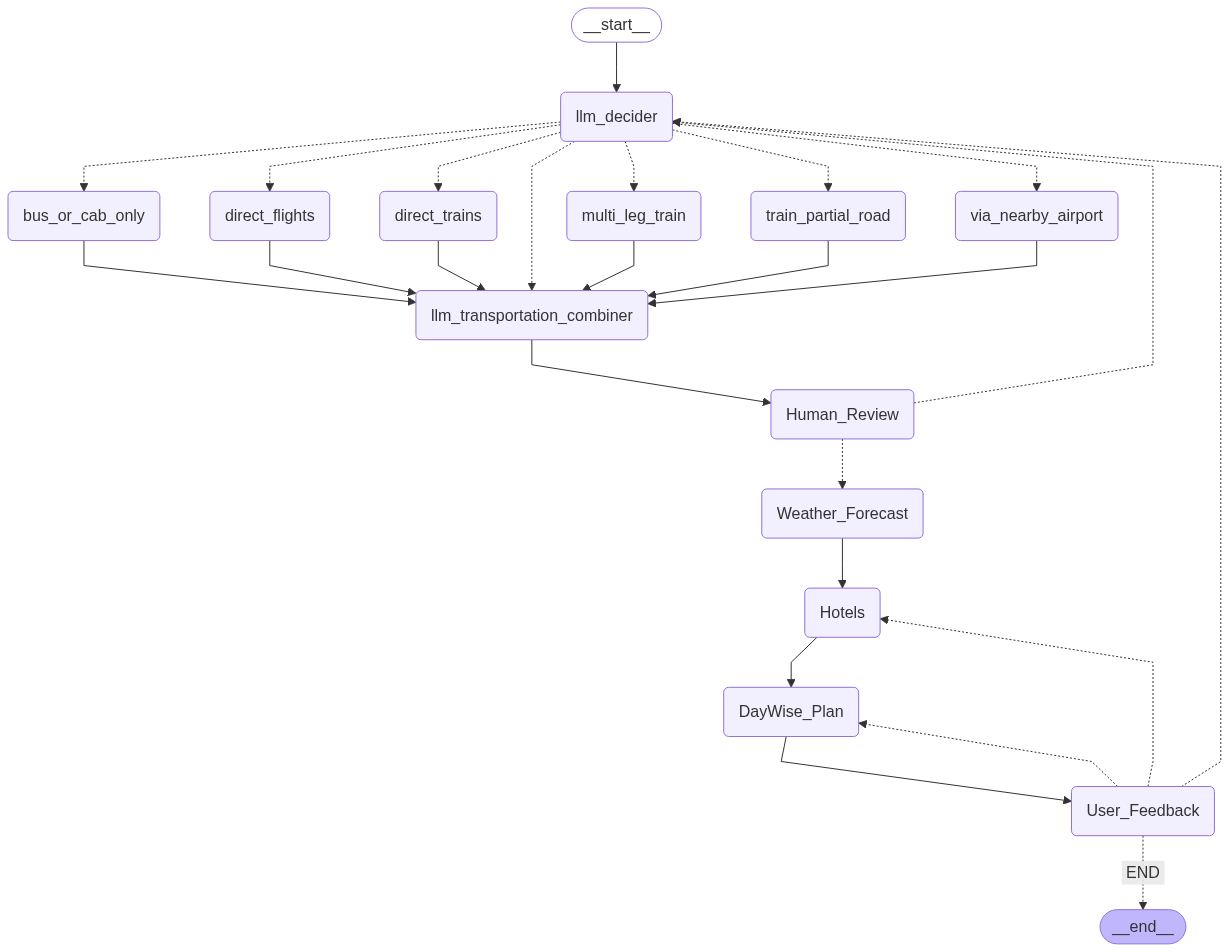

Graph saved as travel_graph.png


In [16]:
# Build the graph
memory = MemorySaver()
graph_builder = StateGraph(State)

# Define the tools (functions) that will be bound
tools = [direct_flights, via_nearby_airport, direct_trains, 
         multi_leg_train, train_partial_road, bus_or_cab_only]

# Bind the tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# Add nodes
graph_builder.add_node("llm_decider", llm_decider)

# Add tool nodes
for tool in tools:
    graph_builder.add_node(tool.__name__, tool)

# Add other nodes
graph_builder.add_node("llm_transportation_combiner", llm_transportation_combiner)
graph_builder.add_node("Weather_Forecast", get_weather_forecast_node)
graph_builder.add_node("Human_Review", human_node)
graph_builder.add_node("DayWise_Plan", wikivoyage_daywise_plan)
graph_builder.add_node("Hotels", search_hotels_serpapi)
graph_builder.add_node("User_Feedback", llm_feedback_router)

# Set entry point
graph_builder.set_entry_point("llm_decider")

# Add conditional edges from decider to appropriate tools
graph_builder.add_conditional_edges(
    "llm_decider",
    should_continue,
    {
        "direct_flights": "direct_flights",
        "via_nearby_airport": "via_nearby_airport",
        "direct_trains": "direct_trains", 
        "multi_leg_train": "multi_leg_train",
        "train_partial_road": "train_partial_road",
        "bus_or_cab_only": "bus_or_cab_only",
        "llm_transportation_combiner": "llm_transportation_combiner"
    }
)

# Add edges from all tools to combiner
for tool in tools:
    graph_builder.add_edge(tool.__name__, "llm_transportation_combiner")

# Add human review after transportation combiner
graph_builder.add_edge("llm_transportation_combiner", "Human_Review")

# Human review condition function
def human_review_condition(state):
    """Determine next node based on human review result"""
    review_result = state.get("human_review_result", "approved")
    
    if review_result == "approved":
        return "Weather_Forecast"
    elif review_result == "needs_modification":
        return "llm_decider"
    else:
        return "Weather_Forecast"  # default to continue

# Add conditional edges from Human_Review
graph_builder.add_conditional_edges(
    "Human_Review",
    human_review_condition,
    {
        "Weather_Forecast": "Weather_Forecast",
        "llm_decider": "llm_decider"
    }
)

# Add edges for the linear flow after human approval
graph_builder.add_edge("Weather_Forecast", "Hotels")
graph_builder.add_edge("Hotels", "DayWise_Plan")
graph_builder.add_edge("DayWise_Plan", "User_Feedback")

# User feedback router function
def llm_feedback_router(state: State) -> State:
    """Handle user feedback and route to appropriate node"""
    plan = state.get("plan", "⚠️ No plan available.")
    print("\n🧭 Here's your current day-wise itinerary:\n")
    print(plan)
    
    user_input = input("Would you like to customize the plan? Say 'Yes' or 'No': ")
    
    if user_input.lower() in ["yes", "y"]:
        user_input2 = input("What customizations would you like to do? ")
        state['human_feedback'] = user_input2
        
        feedback = state.get("human_feedback", "")
        
        prompt = f"""
You are a travel assistant. A user has given the following feedback on their travel plan:

"{feedback}"

Decide which part needs to be updated:
- "Hotels" if they want to change hotels or accommodation
- "DayWise_Plan" if they want to change the itinerary, activities, or schedule
- "llm_decider" if they want to change transportation options
- "END" if no change is required or feedback is unclear

Just respond with the name of the component. Don't include anything else.
"""
        
        result = llm.invoke([HumanMessage(content=prompt)])
        decision = result.content.strip()
        
        return {
            **state,
            "llm_routing_decision": decision
        }
    else:
        return {
            **state,
            "llm_routing_decision": "END"
        }

# Routing function for user feedback
def route_from_llm_decision(state: State) -> str:
    """Route based on LLM decision from user feedback"""
    return state.get("llm_routing_decision", "END")

# Add conditional edges from User_Feedback with proper mapping
graph_builder.add_conditional_edges(
    "User_Feedback",
    route_from_llm_decision,
    {
        "Hotels": "Hotels",
        "DayWise_Plan": "DayWise_Plan", 
        "llm_decider": "llm_decider",
        "END": END  # This should be imported from langgraph
    }
)

# Compile graph with checkpointer
graph = graph_builder.compile(checkpointer=memory)

# Visualize the graph
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except ImportError:
    print("Graph compiled successfully! Install IPython to visualize.")
    
# Optional: Save graph visualization
try:
    with open("travel_graph.png", "wb") as f:
        f.write(graph.get_graph().draw_mermaid_png())
    print("Graph saved as travel_graph.png")
except:
    print("Could not save graph visualization")

In [ ]:
from langchain.schema import HumanMessage

# # Turn structured fields into a readable message
# trip_summary = f"""
# Use the following trip plan to book travel:
# - Origin: {parsed_fields['origin']} ({parsed_fields['src_IATA']})
# - Destination: {parsed_fields['destination']} ({parsed_fields['dest_IATA']})
# - Start Date: {parsed_fields['start_date']}
# - End Date: {parsed_fields['end_date']}
# - Duration: {parsed_fields['duration']} days
# - Budget: {parsed_fields['budget']}
# - Preferences: {parsed_fields['preferences']}
# """
from langchain.schema import HumanMessage
from uuid import uuid4

# Generate config for MemorySaver
config = {"configurable": {"thread_id": str(uuid4())}}

# Proper input format: List[BaseMessage]
input_state = {
    "messages": [
        HumanMessage(content="Plan a trip from Delhi to Mumbai on 28th July for 5 days, 2025. We are 3 persons")
    ]
}

# Invoke the graph
output = graph.invoke(input_state, config=config)

# Print the final message content
print(output["messages"][-1].content)

print(output["plan"])

Raw LLM Output:
 ```json
{
"origin": "Delhi",
"destination": "Mumbai",
"start_date": "2025-07-28",
"end_date": "2025-08-02",
"duration": "5",
"budget": "",
"preferences": "",
"src_IATA": "DEL",
"dest_IATA": "BOM",
"nearby_src_city": "Delhi",
"nearby_dest_city": "Mumbai",
"Persons": "3"
}
```
Delhi
Mumbai
Current transportation recommendations:
**Travel Summary**:
Unfortunately, the direct flights tool failed to provide results. However, I can suggest alternative transportation options for the trip from Delhi to Mumbai.

**Detailed Options**:

**Option 1: Flights with Layover**

* Mode of transport: Flight with layover
* Departure time: 06:00 (Delhi)
* Travel duration: 4 hours 30 minutes (including layover)
* Estimated Arrival Time at Destination: 10:30
* Approximate cost: ₹8,000 - ₹12,000
* Booking suggestions: Check with airlines like IndiGo, SpiceJet, or Air India for available flights with layovers.

**Option 2: Train**

* Mode of transport: Train
* Departure time: 20:00 (Delhi)
* T